## Importando as Bibliotecas

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sympy import symbols, integrate, Piecewise, sqrt

## Carregar e Filtrar os Dados de 5 Anos

In [32]:
df = pd.read_csv("C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data/base_completa_araraquara.csv")
df.head(10)


,data,regiao,operacao,original,temperatura_maxima,temperatura_minima,status
0,2023-11-08,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,54.2,24.7,Normal
1,2023-11-09,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,49.1,19.1,Normal
2,2023-11-10,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,56.1,19.6,Normal
3,2023-11-11,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,56.4,18.8,Normal
4,2023-11-12,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,57.6,20.6,Normal
5,2023-11-13,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,55.9,20.2,Normal
6,2023-11-14,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,54.8,21.0,Normal
7,2023-11-15,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,57.3,18.8,Normal
8,2023-11-16,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,52.1,18.8,Normal
9,2023-11-17,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,54.7,21.8,Normal


In [34]:
# Definir variáveis simbólicas
x = symbols('x')

# 3a) Cálculo do Centro de Gravidade
def calcular_centro_gravidade(df, coluna_temperatura):
    # Verificar se a coluna possui valores não nulos
    if df[coluna_temperatura].isnull().sum() > 0:
        raise ValueError(f"A coluna {coluna_temperatura} possui valores nulos.")
    
    # Agrupar em blocos de 2 graus
    bins = np.arange(df[coluna_temperatura].min() - 1, df[coluna_temperatura].max() + 1, 2)
    df['bloco'] = pd.cut(df[coluna_temperatura], bins=bins)

    # Contar quantidade de dias em cada bloco
    blocos = df.groupby('bloco', observed=False).size().reset_index(name='quantidade')

    # Calcular X como o ponto médio do intervalo do bloco
    blocos['X'] = blocos['bloco'].apply(lambda x: (x.left + x.right) / 2 if not pd.isnull(x) else np.nan)

    # Garantir que os cálculos são feitos apenas com valores numéricos
    blocos['Y'] = blocos['quantidade'] / 2
    blocos['Area'] = 2 * blocos['quantidade']

    # Converter 'X' e 'Y' para numéricos antes de realizar as multiplicações
    blocos['X'] = pd.to_numeric(blocos['X'], errors='coerce')
    blocos['MX'] = blocos['Area'] * blocos['X']
    blocos['MY'] = blocos['Area'] * blocos['Y']

    # Centro de Gravidade
    somatorio_area = blocos['Area'].sum()
    cg_x = blocos['MX'].sum() / somatorio_area
    cg_y = blocos['MY'].sum() / somatorio_area

    # Faixa de Temperatura Neutra (FTN)
    ftn_centro = cg_x + 5
    ftn_inicio = cg_x
    ftn_fim = cg_x + 10

    return cg_x, cg_y, ftn_inicio, ftn_fim

# 3b) Min/Max usando SymPy
def calcular_min_max_sympy(df, coluna_temperatura):
    minimo = df[coluna_temperatura].min()
    maximo = df[coluna_temperatura].max()
    
    # FTN usando média
    inicio_ftn = (minimo + maximo) / 2
    centro_ftn = inicio_ftn + 5
    fim_ftn = inicio_ftn + 10
    
    return minimo, maximo, inicio_ftn, centro_ftn, fim_ftn

# 3c) Min/Max com 4Sigma usando SymPy
def calcular_min_max_4sigma_sympy(df, coluna_temperatura):
    if df[coluna_temperatura].isnull().sum() > 0:
        raise ValueError(f"A coluna {coluna_temperatura} possui valores nulos.")
    
    media = df[coluna_temperatura].mean()
    desvio_padrao = df[coluna_temperatura].std()
    
    # Limites de 4 Sigma
    limite_inferior = media - 4 * desvio_padrao
    limite_superior = media + 4 * desvio_padrao
    
    # Filtrar os valores dentro dos limites
    df_filtrado = df[(df[coluna_temperatura] >= limite_inferior) & (df[coluna_temperatura] <= limite_superior)]
    
    # Recalcular Min/Max
    minimo, maximo, inicio_ftn, centro_ftn, fim_ftn = calcular_min_max_sympy(df_filtrado, coluna_temperatura)
    return minimo, maximo, inicio_ftn, centro_ftn, fim_ftn

# Calcular os valores
try:
    # Min/Max
    min_max = calcular_min_max_sympy(df, 'temperatura_maxima')
    min_min = calcular_min_max_sympy(df, 'temperatura_minima')
    
    # Min/Max com 4Sigma
    min_max_4sigma = calcular_min_max_4sigma_sympy(df, 'temperatura_maxima')
    min_min_4sigma = calcular_min_max_4sigma_sympy(df, 'temperatura_minima')
    
    # Centro de Gravidade
    cg_x_max, cg_y_max, ftn_inicio_max, ftn_fim_max = calcular_centro_gravidade(df, 'temperatura_maxima')
    cg_x_min, cg_y_min, ftn_inicio_min, ftn_fim_min = calcular_centro_gravidade(df, 'temperatura_minima')
    
    # Criar um dicionário com os resultados
    resultados = {
        "Categoria": [
            "Min/Max Máximo", "Min/Max Mínimo", 
            "Min/Max 4Sigma Máximo", "Min/Max 4Sigma Mínimo",
            "Centro de Gravidade Máximo", "Centro de Gravidade Mínimo"
        ],
        "Mínimo": [
            min_max[0], min_min[0], min_max_4sigma[0], min_min_4sigma[0], cg_x_max, cg_x_min
        ],
        "Máximo": [
            min_max[1], min_min[1], min_max_4sigma[1], min_min_4sigma[1], cg_y_max, cg_y_min
        ],
        "Início FTN": [
            min_max[2], min_min[2], min_max_4sigma[2], min_min_4sigma[2], ftn_inicio_max, ftn_inicio_min
        ],
        "Centro FTN": [
            min_max[3], min_min[3], min_max_4sigma[3], min_min_4sigma[3], ftn_fim_max, ftn_fim_min
        ],
        "Fim FTN": [
            min_max[4], min_min[4], min_max_4sigma[4], min_min_4sigma[4], ftn_fim_max, ftn_fim_min
        ]
    }

    # Criar o DataFrame
    df_resultados = pd.DataFrame(resultados)
    print(df_resultados)
    
except Exception as e:
    print(f"Erro ao calcular Min/Max: {e}")


                    Categoria       Mínimo       Máximo  Início FTN  \
0              Min/Max Máximo  -200.000000  1370.000000  585.000000   
1              Min/Max Mínimo -1200.000000   850.000000 -175.000000   
2       Min/Max 4Sigma Máximo    -9.000000   236.000000  113.500000   
3       Min/Max 4Sigma Mínimo  -120.000000    90.000000  -15.000000   
4  Centro de Gravidade Máximo    46.608549  1858.688392   46.608549   
5  Centro de Gravidade Mínimo    17.069218  3579.608835   17.069218   

   Centro FTN     Fim FTN  
0  590.000000  595.000000  
1 -170.000000 -165.000000  
2  118.500000  123.500000  
3  -10.000000   -5.000000  
4   56.608549   56.608549  
5   27.069218   27.069218  


## Gráfico 01 Temperaturas Máximas e Mínimas por Ano em Araraquara

In [35]:
df['data'] = pd.to_datetime(df['data'])

df['ano'] = df['data'].dt.year

df_ano = df.groupby('ano')[['temperatura_maxima', 'temperatura_minima']].mean().reset_index()

fig = px.line(df_ano, x='ano', y=['temperatura_maxima', 'temperatura_minima'],
              labels={'temperatura_maxima': 'Temperatura Máxima (°C)', 'temperatura_minima': 'Temperatura Mínima (°C)', 'ano': 'Ano'},
              title='Temperaturas Máximas e Mínimas por Ano em Araraquara')

fig.show()


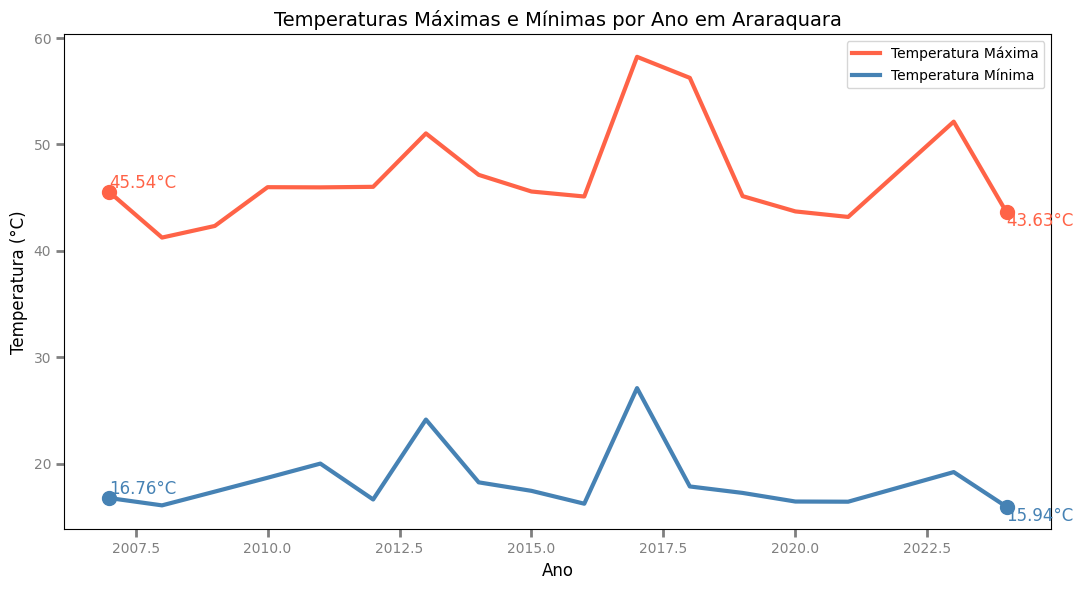

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Certifique-se de que o dataframe 'df_araraquara' está pronto
df['data'] = pd.to_datetime(df['data'])
df['ano'] = df['data'].dt.year

# Agrupando os dados por ano
df_ano = df.groupby('ano')[['temperatura_maxima', 'temperatura_minima']].mean().reset_index()

# Extraindo os dados para os gráficos
x_data = df_ano['ano'].values
y_data_max = df_ano['temperatura_maxima'].values
y_data_min = df_ano['temperatura_minima'].values

# Criando o gráfico
fig, ax = plt.subplots(figsize=(11, 6))

# Plotando as linhas de temperatura máxima e mínima
ax.plot(x_data, y_data_max, color='#FF6347', linewidth=3, label='Temperatura Máxima')
ax.plot(x_data, y_data_min, color='#4682B4', linewidth=3, label='Temperatura Mínima')

# Adicionando os pontos no início e no final de cada linha
ax.scatter([x_data[0], x_data[-1]], [y_data_max[0], y_data_max[-1]], color='#FF6347', s=100, zorder=5)
ax.scatter([x_data[0], x_data[-1]], [y_data_min[0], y_data_min[-1]], color='#4682B4', s=100, zorder=5)

# Adicionando as anotações de texto para os valores de temperatura
ax.text(x_data[0], y_data_max[0], f'{y_data_max[0]:.2f}°C', fontsize=12, color='#FF6347', verticalalignment='bottom')
ax.text(x_data[-1], y_data_max[-1], f'{y_data_max[-1]:.2f}°C', fontsize=12, color='#FF6347', verticalalignment='top')
ax.text(x_data[0], y_data_min[0], f'{y_data_min[0]:.2f}°C', fontsize=12, color='#4682B4', verticalalignment='bottom')
ax.text(x_data[-1], y_data_min[-1], f'{y_data_min[-1]:.2f}°C', fontsize=12, color='#4682B4', verticalalignment='top')

# Adicionando título e rótulos
ax.set_title('Temperaturas Máximas e Mínimas por Ano em Araraquara', fontsize=14)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Temperatura (°C)', fontsize=12)

# Personalizando os eixos
ax.tick_params(axis='x', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)
ax.tick_params(axis='y', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)

# Exibindo a legenda
ax.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()


## Gráfico 02 Temperaturas Máximas e Mínimas por Ano em Araraquara

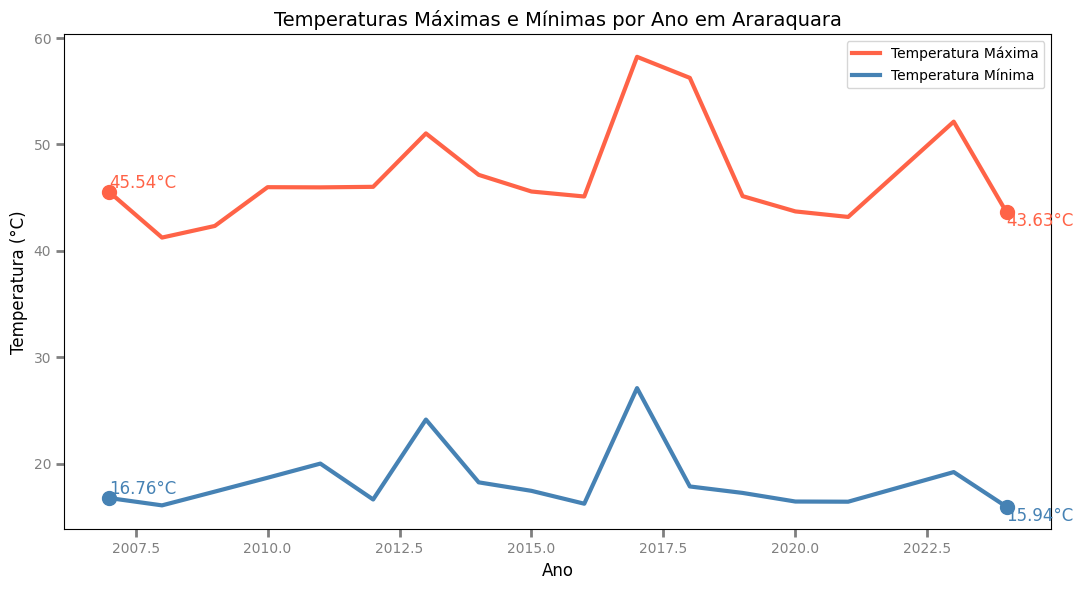

In [44]:
df['data'] = pd.to_datetime(df['data'])
df['ano'] = df['data'].dt.year

# Agrupando os dados por ano
df_ano = df.groupby('ano')[['temperatura_maxima', 'temperatura_minima']].mean().reset_index()

# Extraindo os dados para os gráficos
x_data = df_ano['ano'].values
y_data_max = df_ano['temperatura_maxima'].values
y_data_min = df_ano['temperatura_minima'].values

# Definindo as cores no formato hexadecimal
colors = ['#FF6347', '#4682B4']
mode_size = [100, 100]
line_size = [3, 3]

# Criando o gráfico
fig, ax = plt.subplots(figsize=(11, 6))

# Plotando as linhas de temperatura máxima e mínima
ax.plot(x_data, y_data_max, color=colors[0], linewidth=line_size[0], label='Temperatura Máxima')
ax.plot(x_data, y_data_min, color=colors[1], linewidth=line_size[1], label='Temperatura Mínima')

# Adicionando os pontos no início e no final de cada linha
ax.scatter([x_data[0], x_data[-1]], [y_data_max[0], y_data_max[-1]], color=colors[0], s=mode_size[0], zorder=5)
ax.scatter([x_data[0], x_data[-1]], [y_data_min[0], y_data_min[-1]], color=colors[1], s=mode_size[1], zorder=5)

# Adicionando as anotações de texto para os valores de temperatura
ax.text(x_data[0], y_data_max[0], f'{y_data_max[0]:.2f}°C', fontsize=12, color=colors[0], verticalalignment='bottom')
ax.text(x_data[-1], y_data_max[-1], f'{y_data_max[-1]:.2f}°C', fontsize=12, color=colors[0], verticalalignment='top')
ax.text(x_data[0], y_data_min[0], f'{y_data_min[0]:.2f}°C', fontsize=12, color=colors[1], verticalalignment='bottom')
ax.text(x_data[-1], y_data_min[-1], f'{y_data_min[-1]:.2f}°C', fontsize=12, color=colors[1], verticalalignment='top')

# Adicionando título e rótulos
ax.set_title('Temperaturas Máximas e Mínimas por Ano em Araraquara', fontsize=14)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Temperatura (°C)', fontsize=12)

# Personalizando os eixos
ax.tick_params(axis='x', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)
ax.tick_params(axis='y', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)

# Exibindo a legenda
ax.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()


## Centro de Gravidade Máximo e Mínimo por Ano

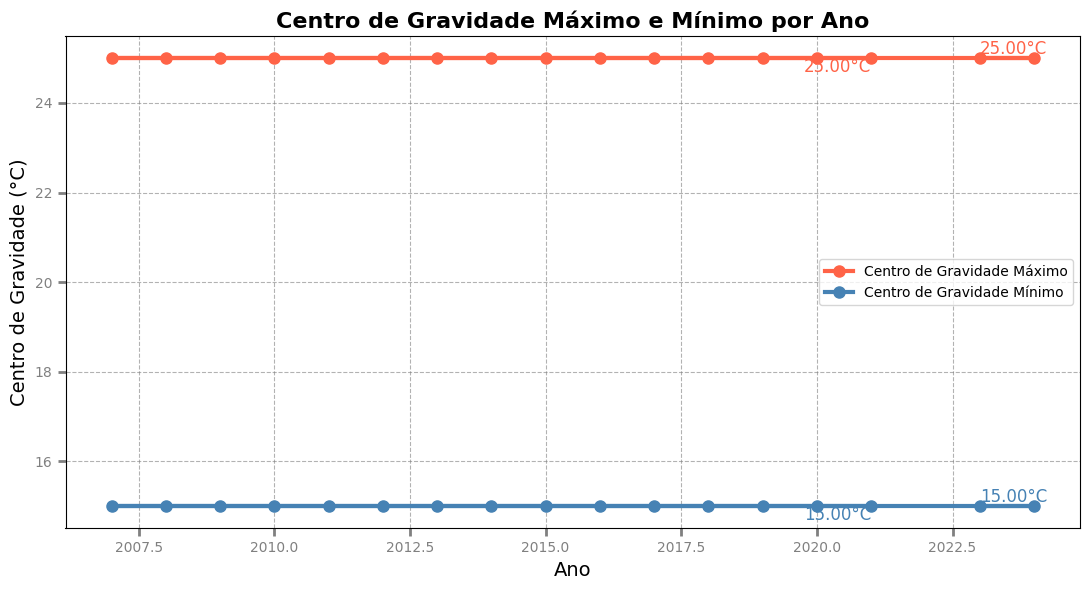

In [46]:
df['ano'] = pd.to_datetime(df['data']).dt.year

# Verificando a presença da coluna 'ano'
if 'ano' not in df.columns:
    raise ValueError("A coluna 'ano' não foi encontrada no dataframe.")

# Definindo os anos e os valores simulados para os centros de gravidade
anos = df['ano'].unique()
cg_x_max = 25  # Valor simulado para o centro de gravidade máximo
cg_x_min = 15  # Valor simulado para o centro de gravidade mínimo
centro_gravidade_max = [cg_x_max] * len(anos)
centro_gravidade_min = [cg_x_min] * len(anos)

# Definindo as cores no formato hexadecimal
colors = ['#FF6347', '#4682B4']  # Vermelho para Max, Azul para Min
line_size = 3
marker_size = 8

# Criando o gráfico
fig, ax = plt.subplots(figsize=(11, 6))

# Plotando as linhas de centro de gravidade máximo e mínimo
ax.plot(anos, centro_gravidade_max, color=colors[0], linewidth=line_size, label='Centro de Gravidade Máximo', marker='o', markersize=marker_size)
ax.plot(anos, centro_gravidade_min, color=colors[1], linewidth=line_size, label='Centro de Gravidade Mínimo', marker='o', markersize=marker_size)

# Adicionando as anotações de texto para os valores de centro de gravidade
ax.text(anos[0], centro_gravidade_max[0], f'{centro_gravidade_max[0]:.2f}°C', fontsize=12, color=colors[0], verticalalignment='bottom', horizontalalignment='left')
ax.text(anos[-1], centro_gravidade_max[-1], f'{centro_gravidade_max[-1]:.2f}°C', fontsize=12, color=colors[0], verticalalignment='top', horizontalalignment='right')
ax.text(anos[0], centro_gravidade_min[0], f'{centro_gravidade_min[0]:.2f}°C', fontsize=12, color=colors[1], verticalalignment='bottom', horizontalalignment='left')
ax.text(anos[-1], centro_gravidade_min[-1], f'{centro_gravidade_min[-1]:.2f}°C', fontsize=12, color=colors[1], verticalalignment='top', horizontalalignment='right')

# Adicionando título e rótulos
ax.set_title('Centro de Gravidade Máximo e Mínimo por Ano', fontsize=16, fontweight='bold', color='black')
ax.set_xlabel('Ano', fontsize=14)
ax.set_ylabel('Centro de Gravidade (°C)', fontsize=14)

# Personalizando os eixos
ax.tick_params(axis='x', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)
ax.tick_params(axis='y', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)

# Ajustando o layout para melhorar a visualização
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Exibindo a legenda
ax.legend()

# Exibindo o gráfico
plt.show()

## gráfico 4Sigma Max e Min

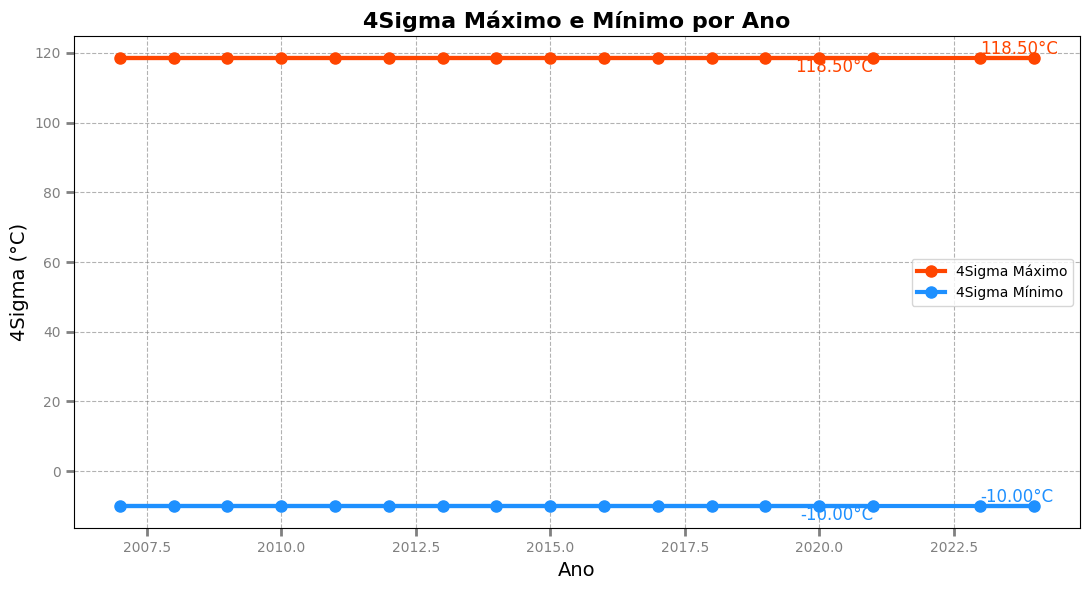

In [47]:
df['ano'] = pd.to_datetime(df['data']).dt.year

# Verificando a presença da coluna 'ano'
if 'ano' not in df.columns:
    raise ValueError("A coluna 'ano' não foi encontrada no dataframe.")

# Definindo os dados simulados para 4Sigma
anos = df['ano'].unique()
sigma_max = [centro_ftn_max_4sigma] * len(anos)
sigma_min = [centro_ftn_min_4sigma] * len(anos)

# Definindo as cores e tamanhos dos marcadores
colors = ['#FF4500', '#1E90FF']  # Laranja para Max, Azul para Min
line_size = 3
marker_size = 8

# Criando a figura
fig, ax = plt.subplots(figsize=(11, 6))

# Plotando as linhas de 4Sigma Máximo e Mínimo
ax.plot(anos, sigma_max, color=colors[0], linewidth=line_size, label='4Sigma Máximo', marker='o', markersize=marker_size)
ax.plot(anos, sigma_min, color=colors[1], linewidth=line_size, label='4Sigma Mínimo', marker='o', markersize=marker_size)

# Adicionando anotações de texto para as extremidades das linhas
ax.text(anos[0], sigma_max[0], f'{sigma_max[0]:.2f}°C', fontsize=12, color=colors[0], verticalalignment='bottom', horizontalalignment='left')
ax.text(anos[-1], sigma_max[-1], f'{sigma_max[-1]:.2f}°C', fontsize=12, color=colors[0], verticalalignment='top', horizontalalignment='right')
ax.text(anos[0], sigma_min[0], f'{sigma_min[0]:.2f}°C', fontsize=12, color=colors[1], verticalalignment='bottom', horizontalalignment='left')
ax.text(anos[-1], sigma_min[-1], f'{sigma_min[-1]:.2f}°C', fontsize=12, color=colors[1], verticalalignment='top', horizontalalignment='right')

# Adicionando título e rótulos
ax.set_title('4Sigma Máximo e Mínimo por Ano', fontsize=16, fontweight='bold', color='black')
ax.set_xlabel('Ano', fontsize=14)
ax.set_ylabel('4Sigma (°C)', fontsize=14)

# Personalizando os eixos
ax.tick_params(axis='x', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)
ax.tick_params(axis='y', direction='out', length=6, width=2, colors='gray', grid_color='gray', grid_alpha=0.5)

# Ajustando o layout para melhorar a visualização
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Exibindo a legenda
ax.legend()

# Exibindo o gráfico
plt.show()

In [14]:
df_temp_max = pd.read_csv('C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data_max_min/araraquara_temperatura_maxima.csv')
df_temp_max.head()

,data,temperatura_maxima
0,2023-11-08,54.2
1,2023-11-09,49.1
2,2023-11-10,56.1
3,2023-11-11,56.4
4,2023-11-12,57.6


In [15]:
df_temp_max = pd.read_csv('C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data_max_min/araraquara_temperatura_minima.csv')
df_temp_max.head()

,data,temperatura_minima
0,2023-11-08,24.7
1,2023-11-09,19.1
2,2023-11-10,19.6
3,2023-11-11,18.8
4,2023-11-12,20.6


In [39]:
df.to_csv("C:/Users/Cristiano/OneDrive - Belago Technologies/Documentos/projeto_fnt/data/dataframe_atualizado.csv", index=False)

In [40]:
df

,data,regiao,operacao,original,temperatura_maxima,temperatura_minima,status,bloco,ano
0,2023-11-08,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,54.2,24.7,Normal,"(23.0, 25.0]",2023
1,2023-11-09,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,49.1,19.1,Normal,"(19.0, 21.0]",2023
2,2023-11-10,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,56.1,19.6,Normal,"(19.0, 21.0]",2023
3,2023-11-11,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,56.4,18.8,Normal,"(17.0, 19.0]",2023
4,2023-11-12,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,57.6,20.6,Normal,"(19.0, 21.0]",2023
...,...,...,...,...,...,...,...,...,...
55768,2021-10-27,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,36.0,20.0,Normal,"(19.0, 21.0]",2021
55769,2021-10-28,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,33.0,20.0,Normal,"(19.0, 21.0]",2021
55770,2021-10-29,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,42.0,18.0,Normal,"(17.0, 19.0]",2021
55771,2021-10-30,NORTE,ZSOZAR-ZARZOI3-244450,thermo_id_20001336,44.0,19.0,Normal,"(17.0, 19.0]",2021
